In [741]:
!pip install ta --quiet

DEPRECATION: Loading egg at /Users/andysstuff/anaconda3/lib/python3.12/site-packages/sympy-1.13.3-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [742]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import joblib 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# from sklearn.preprocessing import MinMaxScaler
# import requests

# Time range: past year
end_date = datetime.now()
start_date = end_date - timedelta(days=1095)

# Download data and include adjusted close
amzn_data = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=False)

# Check available columns
# print("Columns:", amzn_data.columns)

   
# Get PE ratio from metadata
amzn = yf.Ticker("AMZN")
pe_ratio = amzn.info.get('trailingPE', None)

# If PE ratio is not available, set it to NaN
if pe_ratio is None:
    pe_ratio = float('nan')  # Set it to NaN for proper DataFrame handling
else:
    pe_ratio = float(pe_ratio)  # Ensure it's a float

# Create a Series for the PE ratio with the same date index as amzn_data
pe_series = pd.Series(pe_ratio, index=amzn_data.index)

# Combine the PE ratio Series with the historical data
amzn_data['PE_Ratio'] = pe_series

# Daily Volatility (using 7-day rolling standard deviation of log returns)
amzn_data['Log_Return'] = (amzn_data['Adj Close'] / amzn_data['Adj Close'].shift(1)).apply(np.log)
amzn_data['Volatility_7d'] = amzn_data['Log_Return'].rolling(window=7).std()

# Simulated sentiment based on daily percent change
if 'Adj Close' in amzn_data.columns:
    #MA past week
    amzn_data['MA_7'] = amzn_data['Adj Close'].rolling(window=7).mean() 
    #MA past month
    amzn_data['MA_30'] = amzn_data['Adj Close'].rolling(window=30).mean()
    #MA past year
    amzn_data['MA_365'] = amzn_data['Adj Close'].rolling(window=365).mean()

    amzn_data['Pct_Change'] = amzn_data['Adj Close'].pct_change()
    # amzn_data['Sentiment'] = amzn_data['Pct_Change'].apply(
    #     lambda x: 'Bullish' if x > 0 else ('Bearish' if x < 0 else 'Neutral')
    # )
else:
    print("⚠️ 'Adj Close' not found in the data. Cannot compute moving averages or sentiment.")

# # Replace with your Finnhub API key
# api_key = "d07ap6hr01qrslhn6ssgd07ap6hr01qrslhn6st0"
# # Ticker symbol for Amazon
# ticker = "AMZN"

# # Finnhub API endpoint for sentiment analysis
# url = f"https://finnhub.io/api/v1/news-sentiment?symbol={ticker}&token={api_key}"

# # Make the API request
# response = requests.get(url)

# sentiment_data = None
# # Check if the request was successful
# if response.status_code == 200:
#     sentiment_data = response.json()
#     print("Sentiment Data:", sentiment_data)
#     sentiment_score = sentiment_data["sentiment"]
#     amzn_data['Sentiment_score'] = sentiment_score
# else:
#     print("Failed to fetch sentiment data. Status code:", response.status_code)
#     amzn_data['Sentiment_score'] = float('nan')  # Set sentiment score to NaN if API fails


# Check available columns after adding metrics
# Now, modify the second index
new_columns = []

for col in amzn_data.columns:
    # Create a new tuple with the existing first index and 'AMZN' as the second index
    new_columns.append((col[0], 'AMZN'))

# Update the DataFrame's columns
amzn_data.columns = pd.MultiIndex.from_tuples(new_columns)

print("Columns:", amzn_data.columns)

# Display last few rows
print(len(amzn_data))
print(amzn_data.head())
print(amzn_data.tail())

[*********************100%***********************]  1 of 1 completed

Columns: MultiIndex([(    'Adj Close', 'AMZN'),
            (        'Close', 'AMZN'),
            (         'High', 'AMZN'),
            (          'Low', 'AMZN'),
            (         'Open', 'AMZN'),
            (       'Volume', 'AMZN'),
            (     'PE_Ratio', 'AMZN'),
            (   'Log_Return', 'AMZN'),
            ('Volatility_7d', 'AMZN'),
            (         'MA_7', 'AMZN'),
            (        'MA_30', 'AMZN'),
            (       'MA_365', 'AMZN'),
            (   'Pct_Change', 'AMZN')],
           )
751
             Adj Close       Close        High         Low        Open  \
                  AMZN        AMZN        AMZN        AMZN        AMZN   
Date                                                                     
2022-05-02  124.500000  124.500000  124.667999  118.375000  122.401001   
2022-05-03  124.253502  124.253502  126.220497  122.824997  124.053497   
2022-05-04  125.928497  125.928497  126.000000  119.182999  123.599998   
2022-05-05  116.406998

In [743]:
amzn_data.describe()
# print(len(amzn_data))

,Adj Close,Close,High,Low,Open,Volume,PE_Ratio,Log_Return,Volatility_7d,MA_7,MA_30,MA_365,Pct_Change
,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
count,751.000000,751.000000,751.000000,751.000000,751.000000,7.510000e+02,7.510000e+02,750.000000,744.000000,745.000000,722.000000,387.000000,750.000000
mean,149.874180,149.874180,151.749167,147.821760,149.822589,5.523899e+07,3.382491e+01,0.000545,0.020784,149.840120,149.931808,145.665403,0.000813
std,40.897441,40.897441,41.097348,40.607466,40.914245,2.573088e+07,4.052793e-13,0.023124,0.010092,40.808613,40.544655,23.408059,0.023174
min,81.820000,81.820000,83.480003,81.430000,82.800003,1.500750e+07,3.382491e+01,-0.094081,0.004918,83.874286,88.232667,114.283970,-0.089791
25%,115.005001,115.005001,116.915001,113.139999,114.750000,3.867215e+07,3.382491e+01,-0.012157,0.013903,114.928571,114.104251,122.161589,-0.012084
50%,142.300003,142.300003,143.559998,140.089996,142.020004,4.907270e+07,3.382491e+01,0.000378,0.018606,141.157144,137.000334,144.374466,0.000378
75%,183.945000,183.945000,186.044998,181.970001,183.860001,6.477455e+07,3.382491e+01,0.014042,0.024463,183.532859,183.504417,165.812343,0.014141
max,242.059998,242.059998,242.520004,238.029999,239.020004,2.231334e+08,3.382491e+01,0.114915,0.067685,237.695714,230.223333,186.450329,0.121778


In [744]:
amzn_data.info()
# print(len(amzn_data))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 751 entries, 2022-05-02 to 2025-04-29
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, AMZN)      751 non-null    float64
 1   (Close, AMZN)          751 non-null    float64
 2   (High, AMZN)           751 non-null    float64
 3   (Low, AMZN)            751 non-null    float64
 4   (Open, AMZN)           751 non-null    float64
 5   (Volume, AMZN)         751 non-null    int64  
 6   (PE_Ratio, AMZN)       751 non-null    float64
 7   (Log_Return, AMZN)     750 non-null    float64
 8   (Volatility_7d, AMZN)  744 non-null    float64
 9   (MA_7, AMZN)           745 non-null    float64
 10  (MA_30, AMZN)          722 non-null    float64
 11  (MA_365, AMZN)         387 non-null    float64
 12  (Pct_Change, AMZN)     750 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 82.1 KB


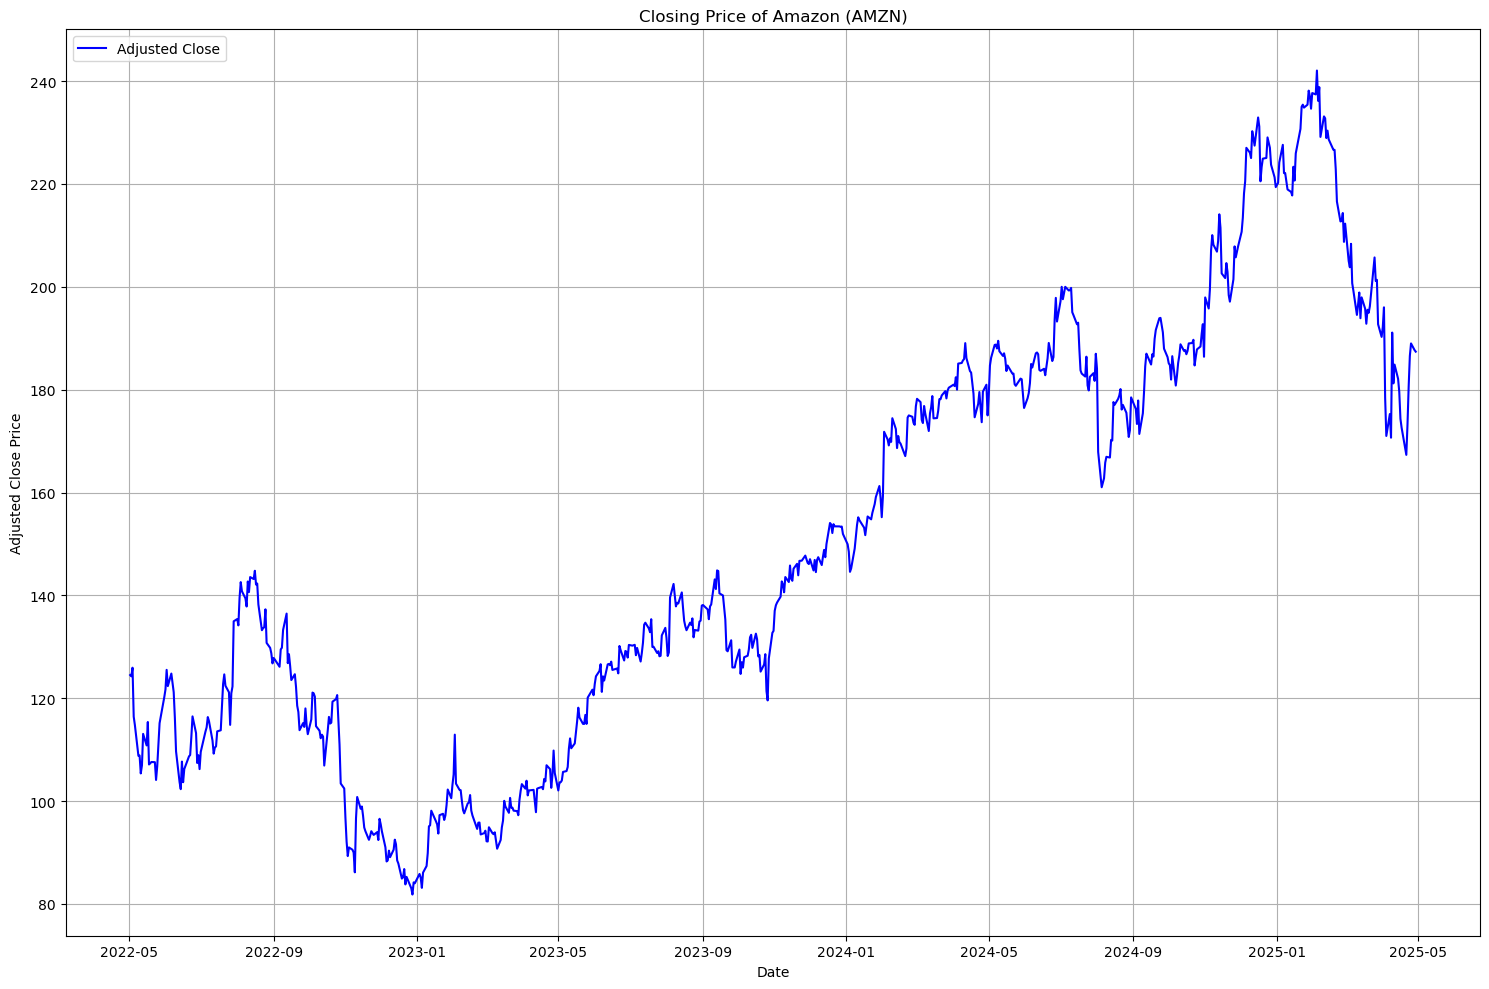

In [745]:

# Time range: past 3 years
# end_date = datetime.now()
# start_date = end_date - timedelta(days=1095)

# Download data for AMZN
# amzn_data = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=False)

# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the adjusted closing price
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.ylabel('Adjusted Close Price')
plt.xlabel('Date')
plt.title("Closing Price of Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout() 
plt.show()


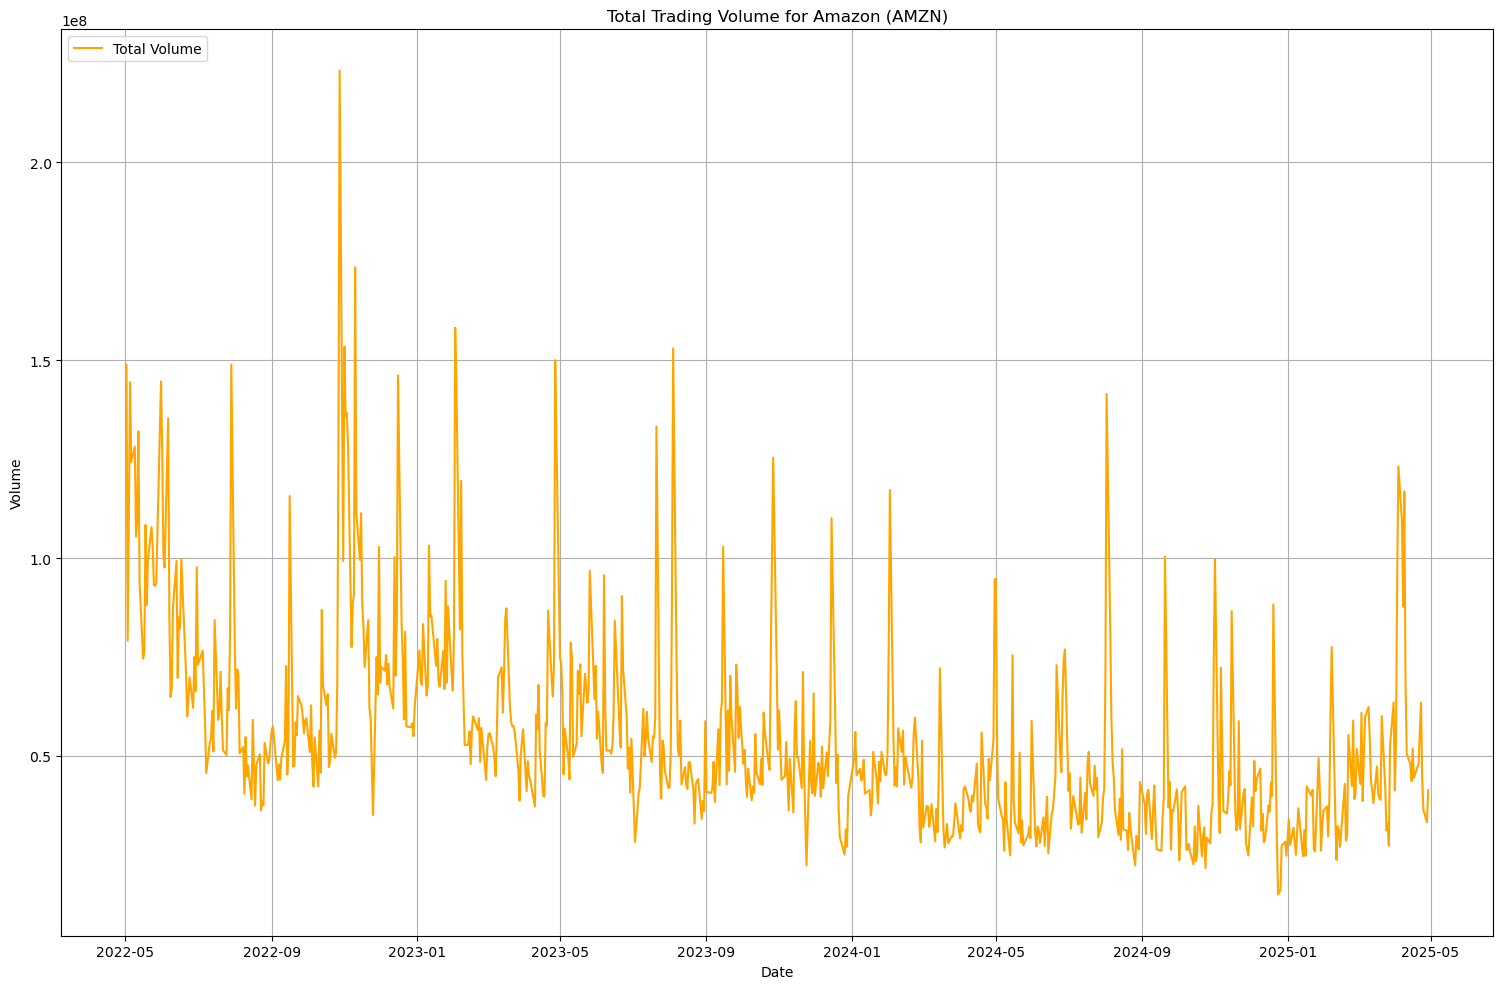

In [746]:
# Now let's plot the total volume of stock being traded each day for Amazon
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the trading volume for AMZN
plt.plot(amzn_data['Volume'], label='Total Volume', color='orange')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Total Trading Volume for Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout() 
plt.show()

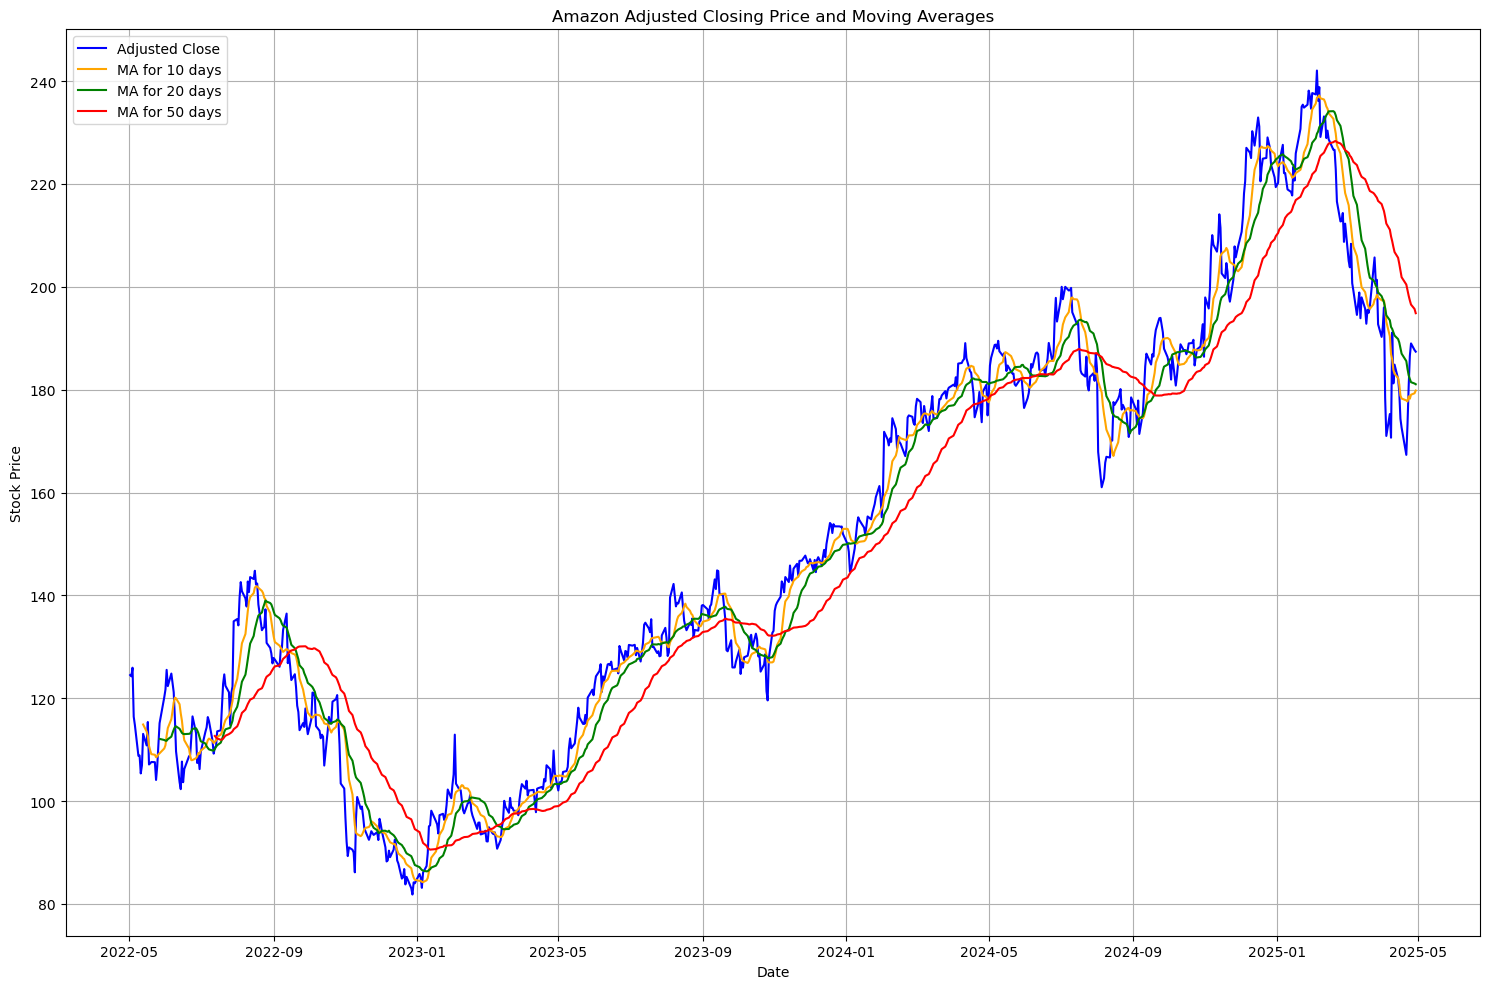

In [747]:
ma_day = [10, 20 ,50]
for ma in ma_day:
    amzn_data[f"MA for {ma} days"] = amzn_data['Adj Close'].rolling(ma).mean()

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=0.2)

# Plotting adjusted close and moving averages
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.plot(amzn_data['MA for 10 days'], label='MA for 10 days', color='orange')
plt.plot(amzn_data['MA for 20 days'], label='MA for 20 days', color='green')
plt.plot(amzn_data['MA for 50 days'], label='MA for 50 days', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title("Amazon Adjusted Closing Price and Moving Averages")
plt.legend()
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()


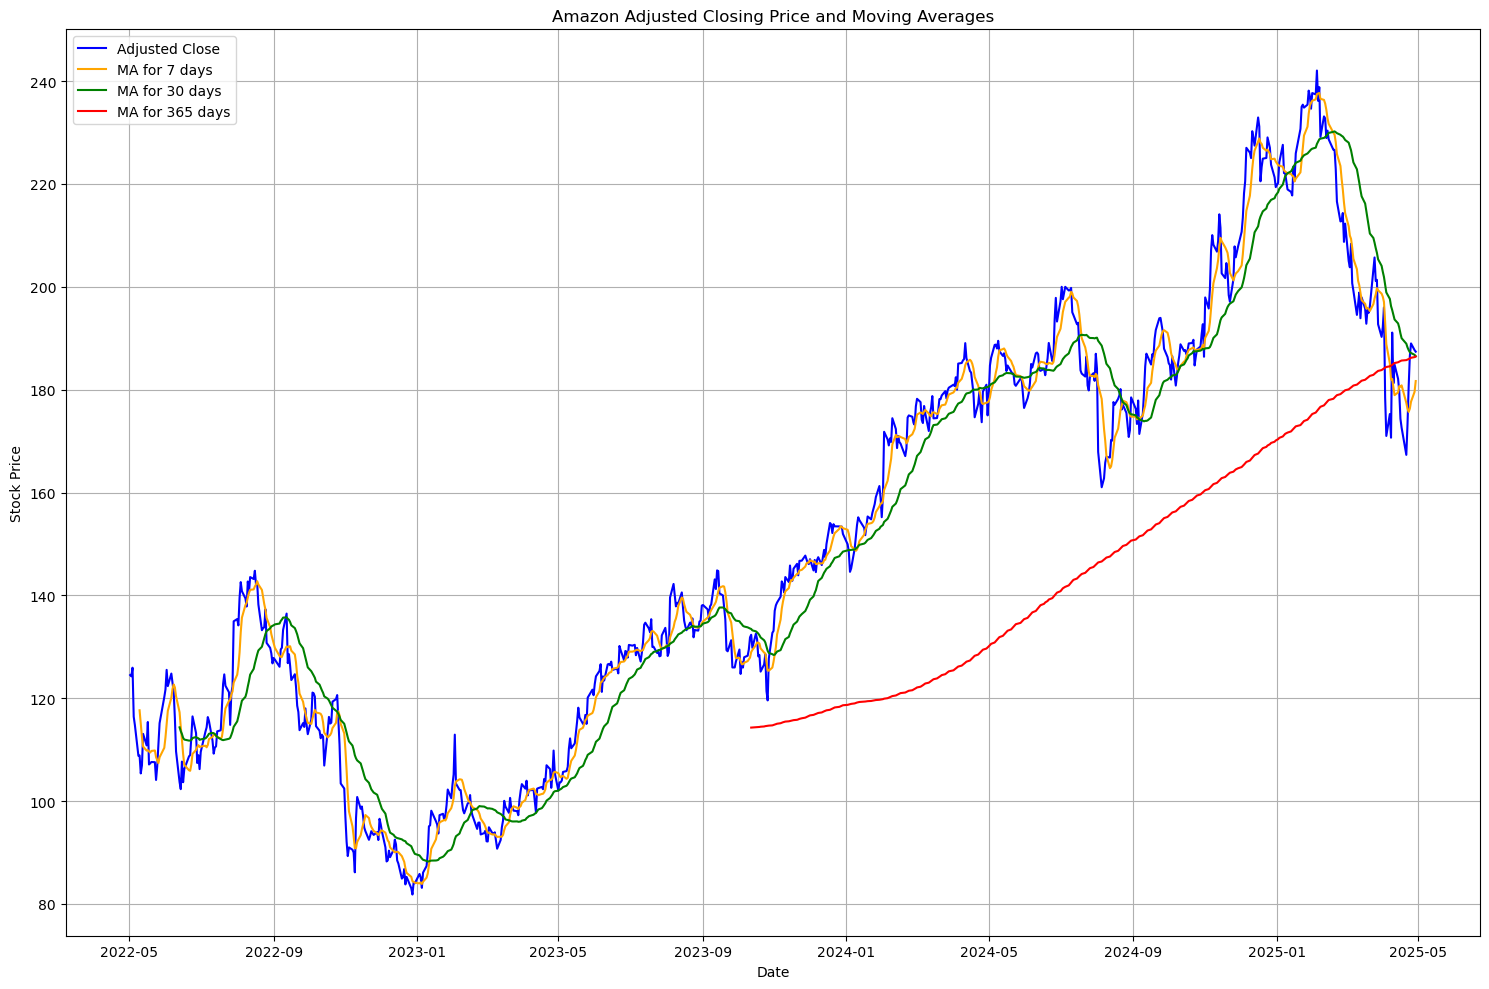

In [748]:

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=0.2)

# Plotting adjusted close and moving averages
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.plot(amzn_data['MA_7'], label='MA for 7 days', color='orange')
plt.plot(amzn_data['MA_30'], label='MA for 30 days', color='green')
plt.plot(amzn_data['MA_365'], label='MA for 365 days', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title("Amazon Adjusted Closing Price and Moving Averages")
plt.legend()
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()


751


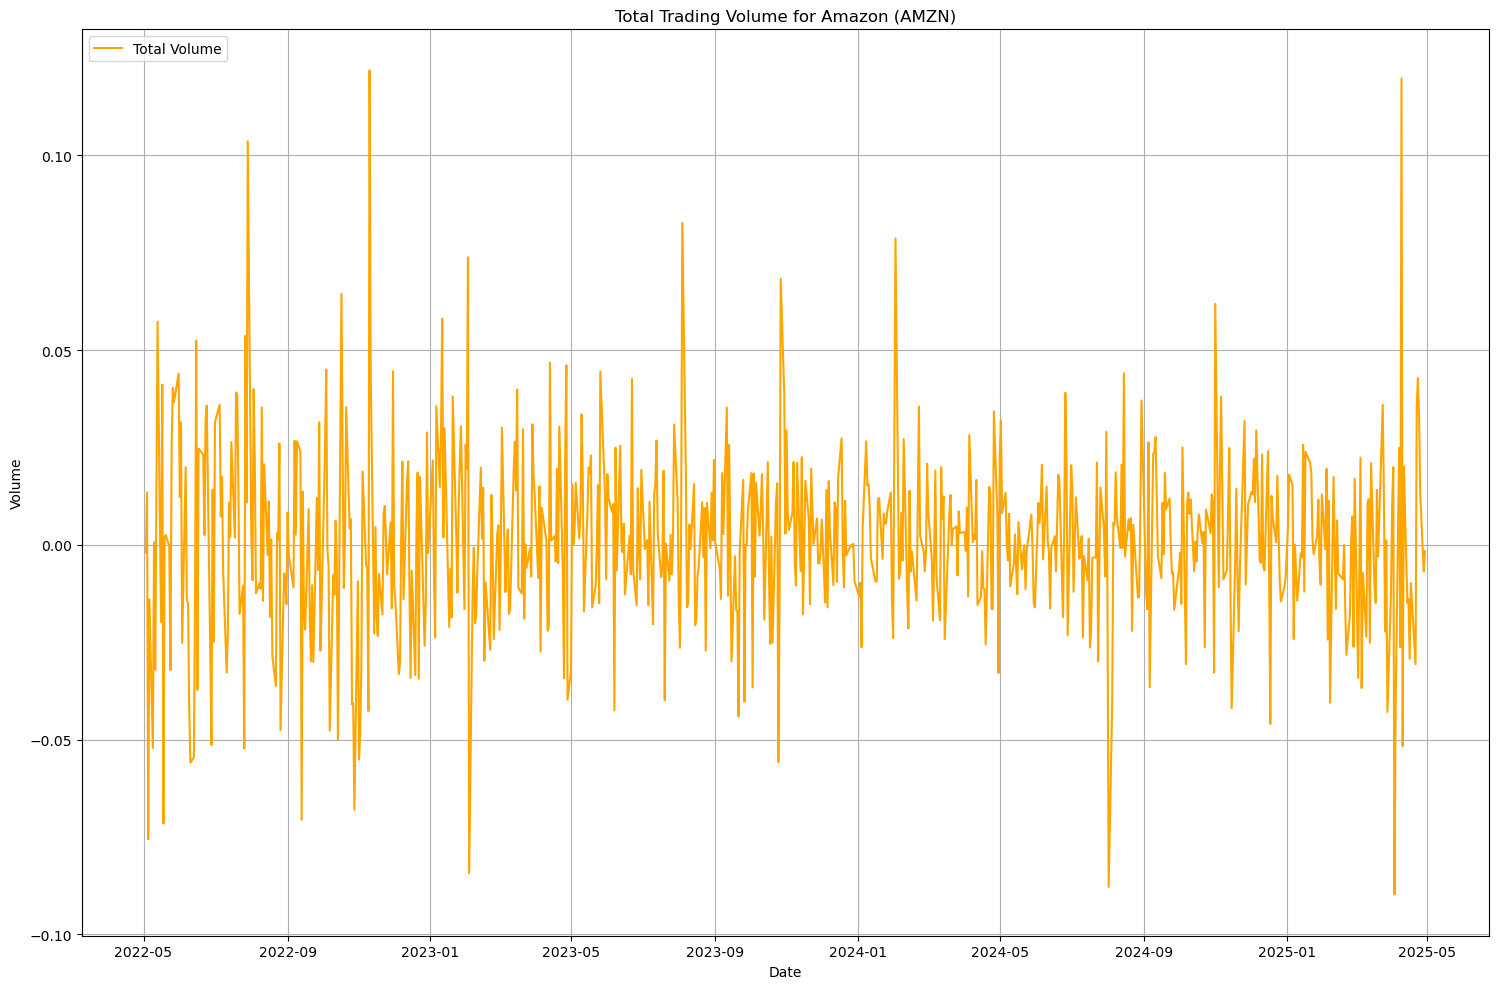

In [749]:
print(len(amzn_data))
# Now let's plot the total volume of stock being traded each day for Amazon
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the trading volume for AMZN
plt.plot(amzn_data['Pct_Change'], label='Total Volume', color='orange')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Total Trading Volume for Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout() 
plt.show()

In [750]:
# Drop NaN values resulting from calculations

print(len(amzn_data))
# Drop NaN values resulting from calculations
amzn_data = amzn_data.dropna()

scaler = StandardScaler()
# Selecting features for training
features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log_Return', 'Pct_Change', 'MA_7', 'MA_30', 'MA_365', 'Volatility_7d', 'PE_Ratio']
data = amzn_data[features]

amzn_data[features] = scaler.fit_transform(amzn_data[features])

751


In [751]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [752]:
X = []
y = []
print(len(amzn_data))
# print(len(amzn_data))
time_steps = 30  # Lookback period
for i in range(time_steps, len(amzn_data)):
    # the line of code below adds all the features from the lookback start to the day before the current 
    X.append(amzn_data[features].iloc[i-time_steps:i].values)  # Use NumPy slicing instead of iloc
    # the line below adds only the 'closing price' feature to y on the currnet day that it's trying to predict
    y.append(amzn_data['Close'].iloc[i])

X, y = np.array(X), np.array(y)

# Train-test split for LSTM
# from sklearn.model_selection import train_test_split
# the 80% to 20% training-test split ensures that the predicted closing prices are not cheating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

387
(285, 30, 13)


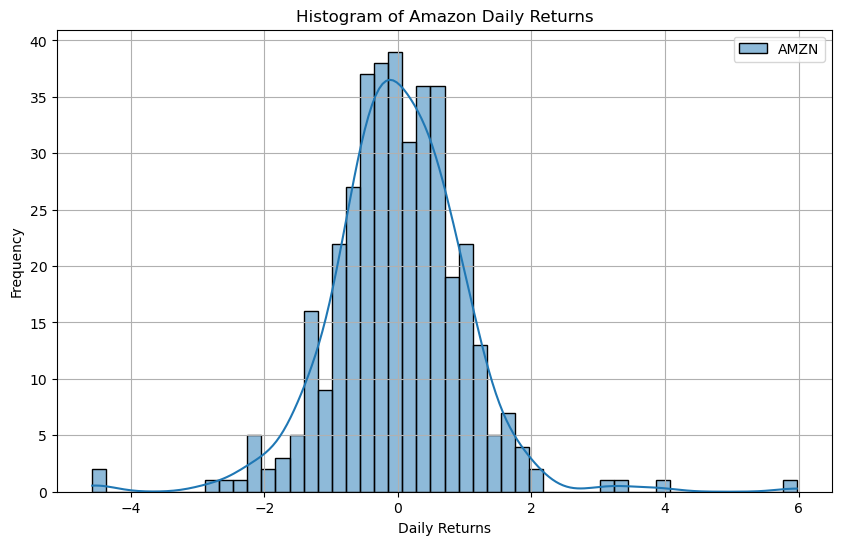

In [753]:

plt.figure(figsize=(10, 6))
sns.histplot(amzn_data['Pct_Change'].dropna(), bins=50, kde=True, color='seagreen')
plt.title('Histogram of Amazon Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid()
plt.show()
  

MultiIndex([(     'Adj Close', 'AMZN'),
            (         'Close', 'AMZN'),
            (          'High', 'AMZN'),
            (           'Low', 'AMZN'),
            (          'Open', 'AMZN'),
            (        'Volume', 'AMZN'),
            (      'PE_Ratio', 'AMZN'),
            (    'Log_Return', 'AMZN'),
            ( 'Volatility_7d', 'AMZN'),
            (          'MA_7', 'AMZN'),
            (         'MA_30', 'AMZN'),
            (        'MA_365', 'AMZN'),
            (    'Pct_Change', 'AMZN'),
            ('MA for 10 days',     ''),
            ('MA for 20 days',     ''),
            ('MA for 50 days',     '')],
           )
           Adj Close     Close      High       Low      Open    Volume  \
                AMZN      AMZN      AMZN      AMZN      AMZN      AMZN   
Date                                                                     
2023-10-12 -1.972909 -1.972909 -1.947803 -1.949050 -1.970106  0.680696   
2023-10-13 -2.071041 -2.071041 -1.992562 -2.038119

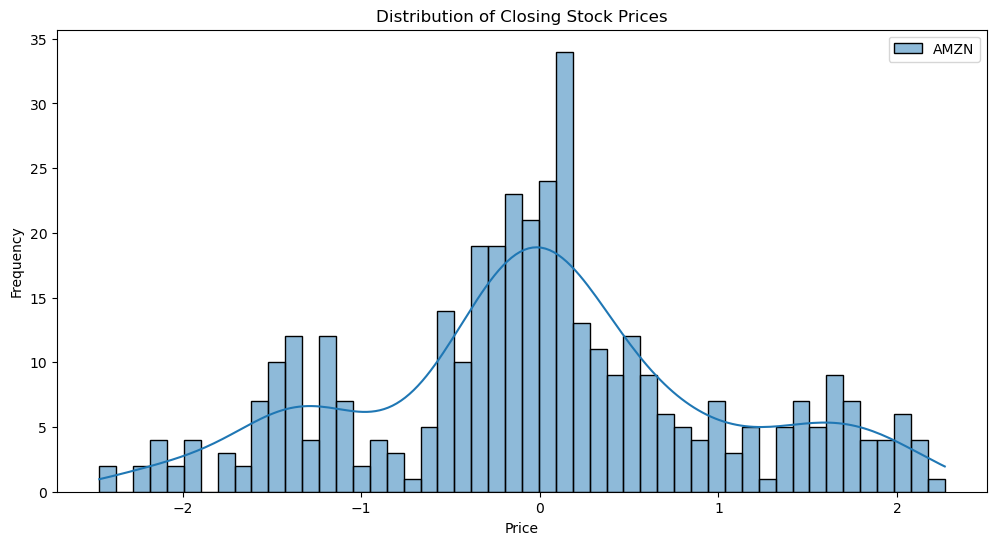

In [754]:

# Convert 'Close' column to numeric
# amzn_data['Close'] = pd.to_numeric(amzn_data['Close'], errors='coerce')
assert isinstance(amzn_data, pd.DataFrame)

print(amzn_data.columns)
# Drop rows with missing 'Close' values
# amzn_data = amzn_data.dropna(subset=['Close'])

print(amzn_data.head())
print(amzn_data.tail())
# Visualize the distribution of 'Close' prices
plt.figure(figsize=(12, 6))
sns.histplot(amzn_data['Close'], bins=50, kde=True, color='blue')
plt.title('Distribution of Closing Stock Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# # Visualize the 'Sentiment_Score'
# plt.figure(figsize=(12, 6))
# sns.histplot(amzn_data['Sentiment'], bins=50, kde=True, color='green')
# plt.title('Distribution of Sentiment Scores')
# plt.xlabel('Sentiment Score')
# plt.ylabel('Frequency')
# plt.show()


In [755]:
# Tuning the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.23),
    Dense(50),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))




Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.3758 - val_loss: 0.1254
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1735 - val_loss: 0.0929
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1163 - val_loss: 0.0550
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0668 - val_loss: 0.0333
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0740 - val_loss: 0.0412
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0623 - val_loss: 0.0286
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0468 - val_loss: 0.0193
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0455 - val_loss: 0.0226
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0443 - val_loss: 0.0197
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0425 - val_loss: 0.0178
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0456 - val_loss: 0.0190
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0430 - val_loss: 0.0146
Epoch 13/50


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


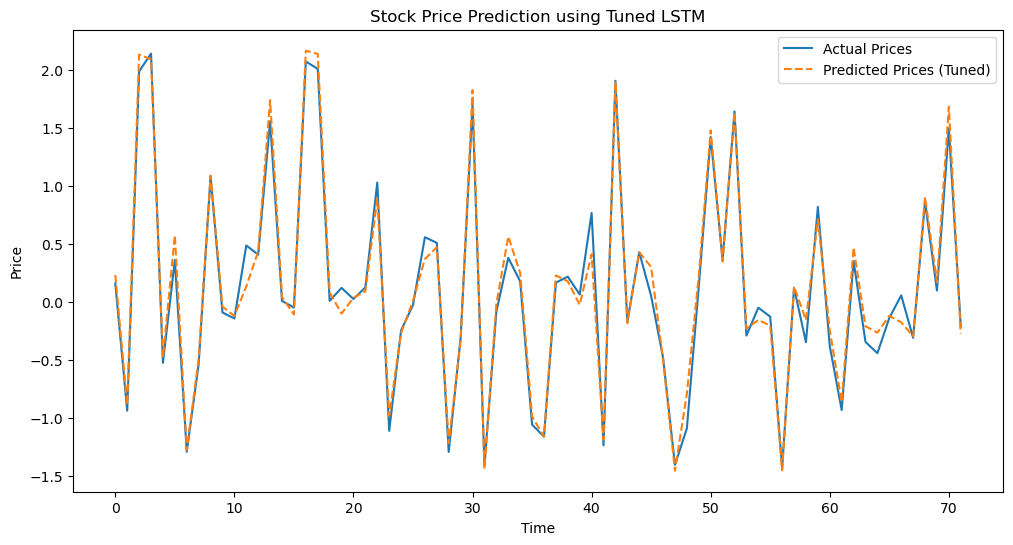

In [756]:
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model = model.predict(X_test)

# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()



In [757]:
# Calculate metrics
mse = mean_squared_error(y_test, lstm_predictions_model)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lstm_predictions_model)
r2 = r2_score(y_test, lstm_predictions_model)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.014470367718183188
Root Mean Squared Error (RMSE): 0.12029284150847543
Mean Absolute Error (MAE): 0.08858675950356025
R-squared (R²): 0.9818480175492943


In [758]:
# Tuning the LSTM model
model2 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.7401 - val_loss: 0.2949
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2265 - val_loss: 0.0685
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1372 - val_loss: 0.0705
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1109 - val_loss: 0.0349
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0848 - val_loss: 0.0324
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0531 - val_loss: 0.0358
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0499 - val_loss: 0.0234
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0504 - val_loss: 0.0213
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0433 - val_loss: 0.0209
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0450 - val_loss: 0.0215
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0456 - val_loss: 0.0224
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0420 - val_loss: 0.0186
Epoch 13/50


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


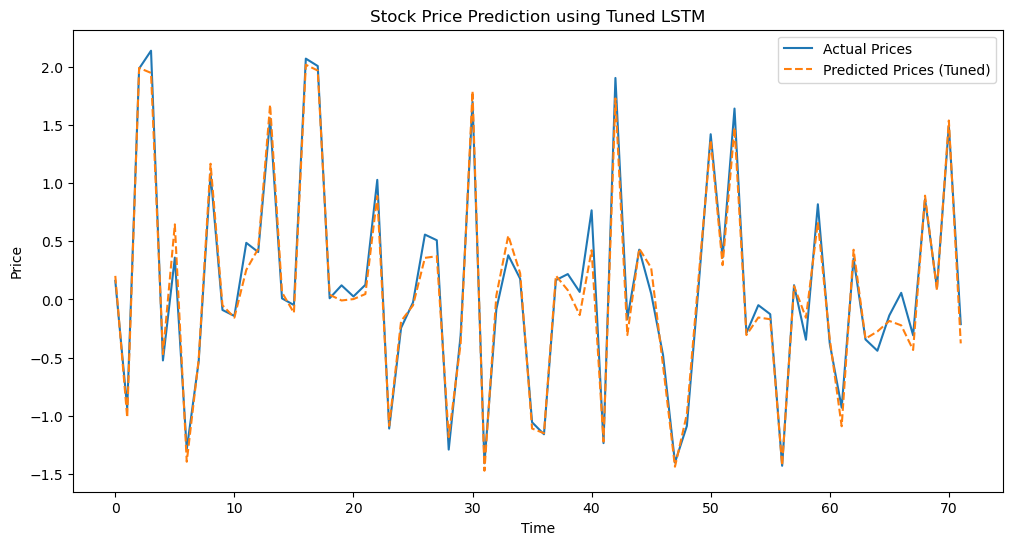

In [759]:
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model2 = model2.predict(X_test)

# lstm_predictions_model2 = lstm_predictions_model2[:, -1, 0]  
# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model2, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [760]:
# Calculate metrics
mse = mean_squared_error(y_test, lstm_predictions_model2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lstm_predictions_model2)
r2 = r2_score(y_test, lstm_predictions_model2)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.014061528180067194
Root Mean Squared Error (RMSE): 0.11858131463290156
Mean Absolute Error (MAE): 0.09203543856114695
R-squared (R²): 0.9823608758446444


In [761]:
# Tuning the LSTM model
model3 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.23),
    LSTM(80, return_sequences=False),
    Dropout(0.23),
    Dense(50),
    Dense(1)
])

# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.5572 - val_loss: 0.1189
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1958 - val_loss: 0.0900
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1476 - val_loss: 0.0747
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1048 - val_loss: 0.0589
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1038 - val_loss: 0.0411
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0752 - val_loss: 0.0304
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0673 - val_loss: 0.0299
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0670 - val_loss: 0.0301
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0596 - val_loss: 0.0217
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0563 - val_loss: 0.0285
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0658 - val_loss: 0.0221
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0530 - val_loss: 0.0276
Epoch 13/50


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


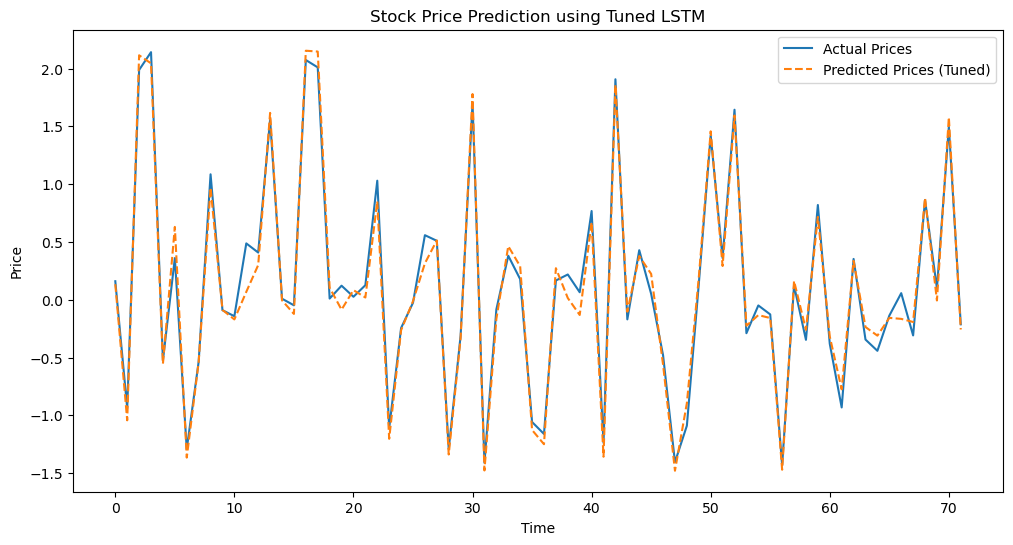

In [762]:
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model3 = model3.predict(X_test)

# lstm_predictions_model3 = lstm_predictions_model3[:, -1, 0]  
# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model3, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [763]:
# Calculate metrics
mse = mean_squared_error(y_test, lstm_predictions_model3)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lstm_predictions_model3)
r2 = r2_score(y_test, lstm_predictions_model3)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.013340090280198249
Root Mean Squared Error (RMSE): 0.1154993085702172
Mean Absolute Error (MAE): 0.09135112871061407
R-squared (R²): 0.9832658651547115


In [764]:
#NEURAL NETWORKS 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten to (num_samples, 390)
X_test = X_test.reshape(X_test.shape[0], -1)     # Flatten to (num_samples, 390)

print(X_train.shape)
print(X_test.shape)
# Creating the Neural Network Model
NNmodel = Sequential()
# Input layer and Hidden layer
NNmodel.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='relu'))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel.compile(loss='mean_squared_error', optimizer='adam')

NNmodel.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


(285, 390)
(72, 390)
Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3627 - val_loss: 0.5697
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5847 - val_loss: 0.5693
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4081 - val_loss: 0.3135
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2346 - val_loss: 0.2780
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1811 - val_loss: 0.2222
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1642 - val_loss: 0.2141
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1223 - val_loss: 0.1677
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1008 - val_loss: 0.1583
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0827 - val_loss: 0.1852
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0677 - val_loss: 0.1558
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0689 - val_loss: 0.1507
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0528 - val_loss: 0.1595
Epoch 13/50
5/5 ━━━━━━━

In [765]:
NN_predictions_model = NNmodel.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


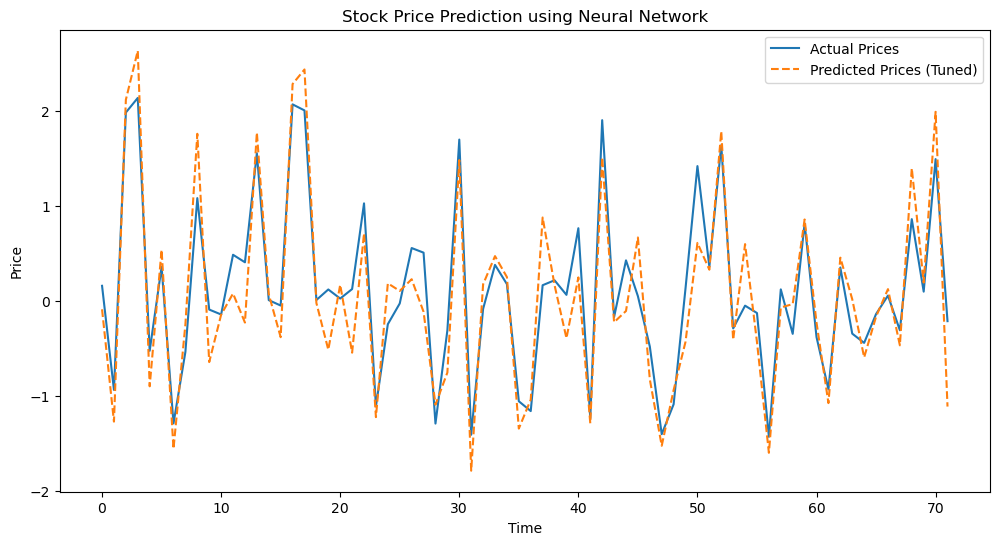

In [766]:

# Plot the results for the tuned NN model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(NN_predictions_model, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [767]:
# Calculate metrics
mse = mean_squared_error(y_test, NN_predictions_model)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, NN_predictions_model)
r2 = r2_score(y_test, NN_predictions_model)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.13979356465147105
Root Mean Squared Error (RMSE): 0.3738897760724022
Mean Absolute Error (MAE): 0.30454488440397237
R-squared (R²): 0.8246395404944353


In [768]:
# Creating the Neural Network Model
NNmodel2 = Sequential()
# Input layer and Hidden layer
# print(X.shape[2])
NNmodel2.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel2.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel2.compile(loss='mean_squared_error', optimizer='adam')

NNmodel2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.9580 - val_loss: 5.5110
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3276 - val_loss: 5.0703
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8771 - val_loss: 4.5886
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4276 - val_loss: 4.1472
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0229 - val_loss: 3.7520
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6438 - val_loss: 3.3877
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2819 - val_loss: 3.0565
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9551 - val_loss: 2.7413
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6449 - val_loss: 2.4539
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3717 - val_loss: 2.1915
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1165 - val_loss: 1.9583
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8888 - val_loss: 1.7499
Epoch 13/50
5/5 ━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


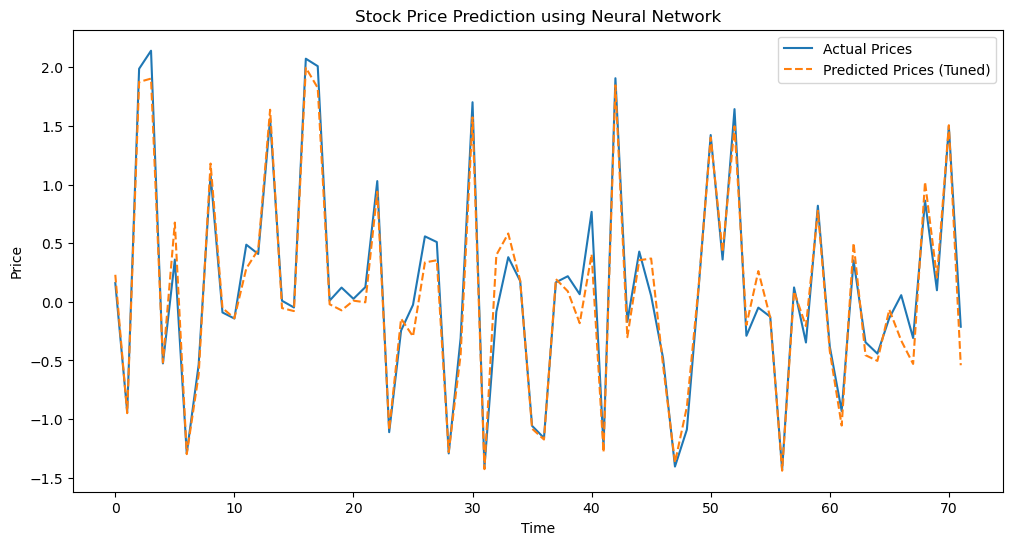

In [769]:
NN_predictions_model2 = NNmodel2.predict(X_test)

# Plot the results for the tuned NN model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(NN_predictions_model2, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [770]:
# Calculate metrics
mse = mean_squared_error(y_test, NN_predictions_model2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, NN_predictions_model2)
r2 = r2_score(y_test, NN_predictions_model2)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.024416525123437924
Root Mean Squared Error (RMSE): 0.1562578801962894
Mean Absolute Error (MAE): 0.11448930865554423
R-squared (R²): 0.9693713149396381


In [771]:
NNmodel3 = Sequential()
# Input layer and Hidden layer
NNmodel3.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel3.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))

NNmodel3.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel3.compile(loss='mean_squared_error', optimizer='adam')

NNmodel3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.1639 - val_loss: 8.5968
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4375 - val_loss: 7.9226
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8453 - val_loss: 7.5335
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3979 - val_loss: 7.0131
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.9240 - val_loss: 6.5919
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4957 - val_loss: 6.1575
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0680 - val_loss: 5.7660
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6695 - val_loss: 5.3874
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3000 - val_loss: 5.0297
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9451 - val_loss: 4.6969
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6176 - val_loss: 4.3845
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3094 - val_loss: 4.0937
Epoch 13/50
5/5 ━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


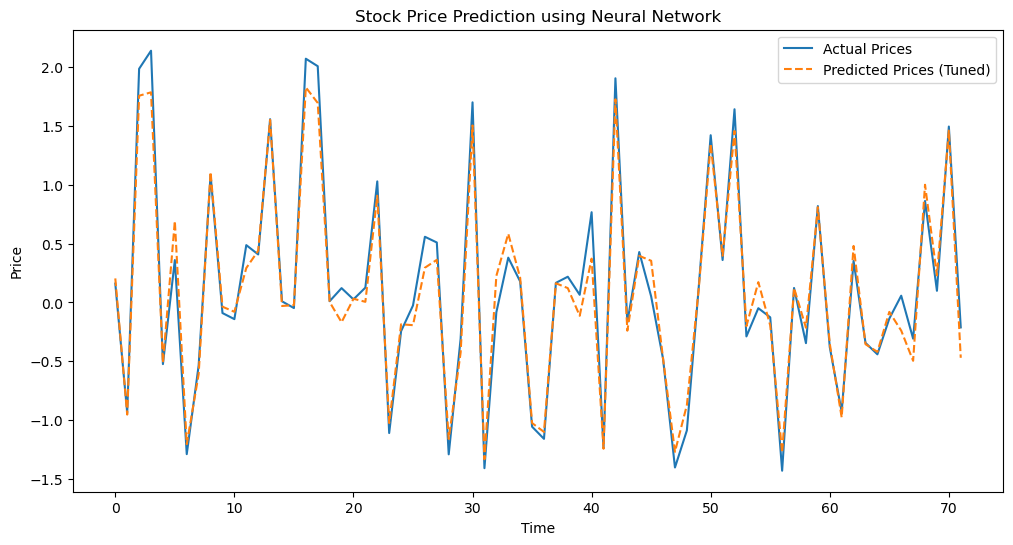

In [772]:
NN_predictions_model3 = NNmodel3.predict(X_test)

# Plot the results for the tuned NN model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(NN_predictions_model3, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [773]:
# Calculate metrics
mse = mean_squared_error(y_test, NN_predictions_model3)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, NN_predictions_model3)
r2 = r2_score(y_test, NN_predictions_model3)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.024404663450059254
Root Mean Squared Error (RMSE): 0.15621992014483702
Mean Absolute Error (MAE): 0.11807963200441561
R-squared (R²): 0.9693861945122377


In [774]:
NNmodel4 = Sequential()
# Input layer and Hidden layer
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='relu', kernel_regularizer=l2(0.1)))
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='sigmoid', kernel_regularizer=l2(0.1)))
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))

NNmodel4.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel4.compile(loss='mean_squared_error', optimizer='adam')

NNmodel4.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 18.2958 - val_loss: 17.3067
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 17.0351 - val_loss: 16.2300
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15.9584 - val_loss: 15.1644
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.9415 - val_loss: 14.1735
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.9637 - val_loss: 13.2605
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.0014 - val_loss: 12.4095
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.1995 - val_loss: 11.6233
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.4199 - val_loss: 10.8895
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.7070 - val_loss: 10.2112
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.0520 - val_loss: 9.5855
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4682 - val_loss: 9.0066
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8743 - val_loss: 8.4744
Epoc

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


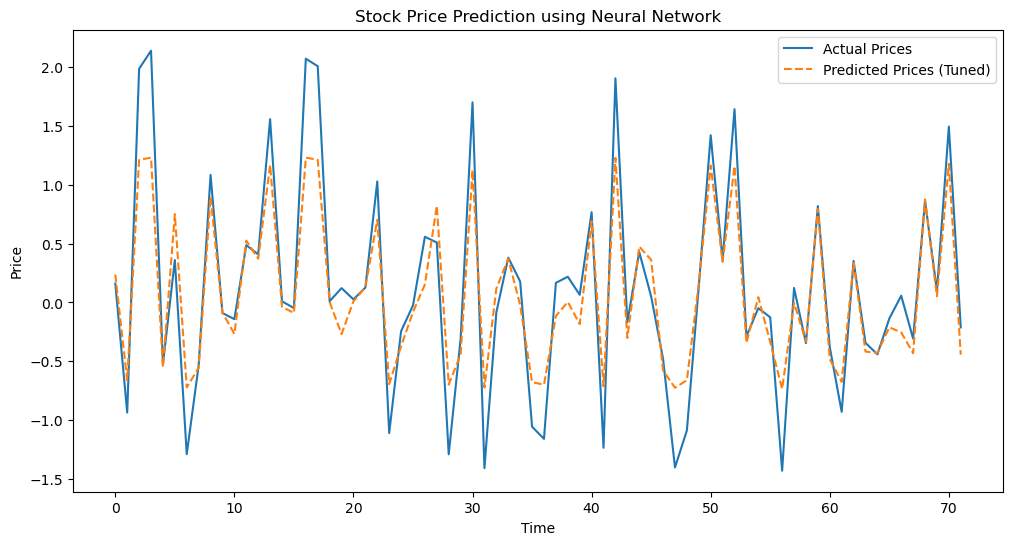

In [775]:
NN_predictions_model4 = NNmodel4.predict(X_test)

# Plot the results for the tuned NN model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(NN_predictions_model4, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [776]:
# Calculate metrics
mse = mean_squared_error(y_test, NN_predictions_model4)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, NN_predictions_model4)
r2 = r2_score(y_test, NN_predictions_model4)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.12190113792761098
Root Mean Squared Error (RMSE): 0.3491434346047638
Mean Absolute Error (MAE): 0.25225795915948457
R-squared (R²): 0.847084237285653
